# Hamiltonian simulation with Gray code encoding - statevector simulator

In [15]:
import numpy as np
np.warnings.filterwarnings('ignore')

import pickle

from scipy.linalg import expm
from scipy.linalg import eigh
from scipy.linalg import eig
# import scipy
from pprint import pprint
from tqdm import tqdm

from scipy.linalg import lstsq
# import scipy as sp

# Everything we need from Qiskit
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute, Aer
from qiskit.quantum_info import Pauli

from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.aqua.components.initial_states import Custom

import qutip as qt
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(16,8)})
sns.set()

import itertools

import sys
sys.path.append("../src/")
from hamiltonian import *
from utils import *
from qiskit_circuits import *
from qite import *

## Playing with Pauli and WeightedPauli operators

In [16]:
## H is always in qiskit order (right to left)
## String form is also in that order 
## State vector results in order [00,01,10,11]

hw,J=1.0,1 ## hw reset internally by toy hamilonian
Nmax=4
encoding="Graycode"
H = hamiltonian_matrix(Nmax,hw,J,"toy_hamiltonian") 
exact_eigenvalue,_=eigh(H)
print(exact_eigenvalue)

H_qubit = GrayCodeHamiltonian(H)
n_qubits=H_qubit.N_qubits

print(H_qubit.pauli_coeffs)



[-2.0456709   8.56158173 24.54750806]
{'II': (7.7658547225+0j), 'IZ': (-7.9841452775+0j), 'ZI': (-1.8591452774999997+0j), 'ZZ': (1.6408547225000003+0j), 'IX': (-2.1433035249352805+0j), 'ZX': (-2.1433035249352805+0j), 'XI': (-3.913118960624632+0j), 'XZ': (3.913118960624632+0j)}


In [17]:
## vector of WeightedPauliOperators representing vector Sigma -- a list of all pauli terms with odd number of Y gates
sigmas=sigma_terms(n_qubits)

## b=i[H,sigma]
b_pauli_terms=b_terms(H_qubit,sigmas)

##S_{ij}=2sigma_i.sigma_j
S_pauli_terms=S_terms(sigmas)

## Set of all pauli terms needed to compute H, b, and S
pauli_set=get_intersection_pauli_terms(H_qubit,b_pauli_terms,S_pauli_terms)

## Organize pauli set into commuting sets of pauli operators 
commuting_sets=get_commuting_sets(sorted(pauli_set))
print("key, [paulis in set]")
for p in commuting_sets:
    print(p, commuting_sets[p])

key, [paulis in set]
XX ['II', 'IX', 'XI', 'XX']
XY ['IY', 'XY']
XZ ['IZ', 'XZ']
YX ['YI', 'YX']
YY ['YY']
YZ ['YZ']
ZX ['ZI', 'ZX']
ZY ['ZY']
ZZ ['ZZ']


In [10]:
#####################################       
# Prepare and run the evolution circuit
#####################################       
num_iterations=20
delta_time=0.01



Nmax=14
H = hamiltonian_matrix(Nmax,hw,J,"toy_hamiltonian") 
exact_eigenvalue,_=eigh(H)
print(exact_eigenvalue)

H_qubit = GrayCodeHamiltonian(H)
n_qubits=H_qubit.N_qubits
print(n_qubits)

initialization="zeros"


backend = 'statevector_simulator'
sv_energies,Ccoefs_sv=run_qite_experiment(H_qubit,num_iterations,delta_time,backend,initialization,A_threshold=1e-10,cstep=None)

threshold=1e-2
backend = 'qasm_simulator'
qasm_energies,Ccoefs_qasm=run_qite_experiment(H_qubit,num_iterations,delta_time,backend,initialization,A_threshold=threshold,cstep=2)



  0%|          | 0/20 [00:00<?, ?it/s]

[-2.21503787  2.52159867  8.32143272 16.32766303 26.59557563 39.95924445
 57.74792829 83.05501397]
3


100%|██████████| 20/20 [00:49<00:00,  2.47s/it]


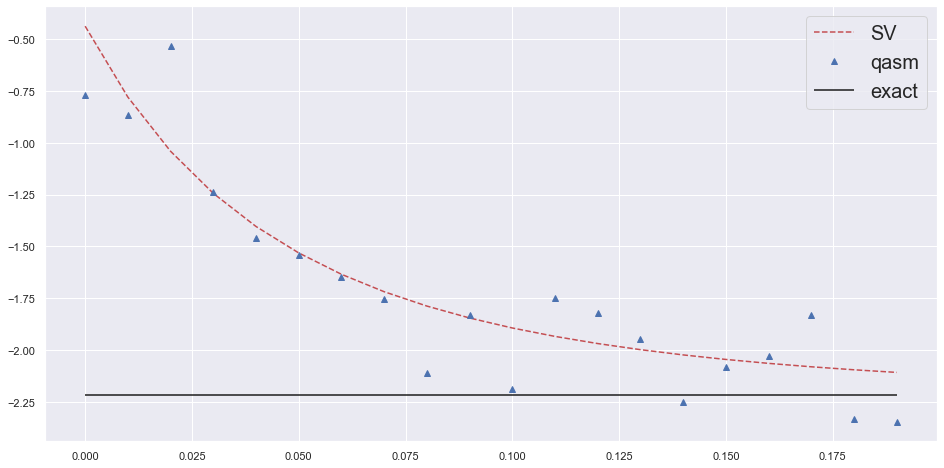

In [11]:
time=[delta_time*t for t in range(num_iterations)]
plt.plot(time,sv_energies,'r--',label="SV")
plt.plot(time,qasm_energies,'b^',label="qasm")
plt.hlines(exact_eigenvalue[0], time[0], time[-1], colors='k', linestyles='solid', label='exact',)
plt.legend(prop={'size': 20})

In [18]:
def normalization_coefficient(ncoefs,Ccoefs,r):
    nr=ncoefs[r-1]
    Cr=Ccoefs[r-1]
    return nr/np.sqrt(Cr)

def normalization_coefficients(Ccoef):
    ncoefs=np.zeros(len(Ccoef))
    ncoefs[0]=1/np.sqrt(Ccoef[0])
    for r in range(1,len(Ccoef)):
        
#         Cr=Ccoef[r-1]
#         nr=ncoefs[r-1]
        ncoefs[r]=normalization_coefficient(ncoefs,Ccoef,r)
    
    return ncoefs

ncoefs=normalization_coefficients(Ccoefs_sv)
print(ncoefs)

[0.99566257 0.99134396 0.98371098 0.97363315 0.96174749 0.94852753
 0.93432968 0.91942514 0.90402231 0.88828271 0.87233242 0.85627053
 0.84017528 0.82410872 0.80812016 0.7922489  0.77652621 0.76097694
 0.74562079 0.73047324]


In [19]:
# from scipy.linalg import eig
## Construct overlap matrix
lanczos_stride=4
max_krylov_dim=8

ncoefs=normalization_coefficients(Ccoefs_sv)
print(ncoefs)

regularization_factors={}
index_list=[0]
thres=.999
for i in range(2,len(ncoefs),2):
    j=index_list[-1]
    k=int((i+j)/2)
    regularization_factor=(ncoefs[i]*ncoefs[j])/(ncoefs[k]**2)
    print(i,regularization_factor)
    if regularization_factor<thres:
        index_list.append(i)
        regularization_factors[i]=regularization_factor
    
dim=min(len(index_list),max_krylov_dim)

index_list=index_list[-dim:]
print(index_list)

Omatrix=np.asmatrix(np.zeros((dim,dim)))
Hmatrix=np.asmatrix(np.zeros((dim,dim)))

for i in range(dim):
    for j in range(dim):
        l=index_list[j]
        lp=index_list[i]
        k=int((l+lp)/2)
        Omatrix[i,j]=(ncoefs[l]*ncoefs[lp])/(ncoefs[k]**2)

## Construct H matrix 
for i in range(0,dim):
    for j in range(0,dim):
        l=index_list[j]
        lp=index_list[i]
        k=int((l+lp)/2)
        Hmatrix[i,j]=Omatrix[i,j]*sv_energies[k]
# print(Hmatrix)


eigs,_=eigh(Hmatrix,Omatrix)
print(eigs)
print("")
print("Num iterations: ",num_iterations)
print("QITE:     ",sv_energies[-1])
print("QLanczos: ",eigs.real[0])
print("Exact:    ",exact_eigenvalue[0])

[0.99566257 0.99134396 0.98371098 0.97363315 0.96174749 0.94852753
 0.93432968 0.91942514 0.90402231 0.88828271 0.87233242 0.85627053
 0.84017528 0.82410872 0.80812016 0.7922489  0.77652621 0.76097694
 0.74562079 0.73047324]
2 0.9966231570385965
4 0.9980168591930022
6 0.9987604191441732
8 0.9991864728046412
10 0.9972955000146124
12 0.9996084491931496
14 0.9986611487548469
16 0.9997899550840248
18 0.9992673907267211
[0, 2, 4, 6, 10, 14]
[-2.21418681  2.63012851  8.39332451 15.91539599 24.9228071  35.66895379]

Num iterations:  20
QITE:      -2.107838690508586
QLanczos:  -2.214186810596796
Exact:     -2.0456708984064313


In [20]:
## Construct overlap matrix and H matrix in Krylov basis
lanczos_stride=2
max_krylov_dim=4

ncoefs=normalization_coefficients(Ccoefs_qasm)
# print(ncoefs)

regularization_factors={}
index_list=[0]
thres=.999
for i in range(2,len(ncoefs),2):
    j=index_list[-1]
    k=int((i+j)/2)
    regularization_factor=(ncoefs[i]*ncoefs[j])/(ncoefs[k]**2)
#     print(i,regularization_factor)
    if regularization_factor<thres:
        index_list.append(i)
        regularization_factors[i]=regularization_factor

# print("stride",lanczos_stride)
# index_list=[]
# for i in range(0,num_iterations,lanczos_stride):
#     index_list.append(i)

dim=min(len(index_list),max_krylov_dim)

index_list=index_list[-dim:]
# index_list=index_list[:dim]
print(index_list)

Omatrix=np.asmatrix(np.zeros((dim,dim)))
Hmatrix=np.asmatrix(np.zeros((dim,dim)))

for i in range(dim):
    for j in range(dim):
        l=index_list[j]
        lp=index_list[i]
        k=int((l+lp)/2)
        Omatrix[i,j]=(ncoefs[l]*ncoefs[lp])/(ncoefs[k]**2)

Oeigs,Ovecs=eig(Omatrix)
print(Oeigs)
threshold=1e-2
Odiag=np.zeros((dim,dim))
for i in range(dim):
    if abs(Oeigs[i].real)>threshold:
        Odiag[i,i]=Oeigs[i]

print(Omatrix)
Omatrix2=np.dot(Ovecs.transpose(),np.dot(Odiag,Ovecs))
print("")
print(Omatrix2)
print("")
        
## Construct H matrix 
for i in range(0,dim):
    for j in range(0,dim):
        l=index_list[j]
        lp=index_list[i]
        k=int((l+lp)/2)
        Hmatrix[i,j]=Omatrix2[i,j]*qasm_energies[k]
# print(Hmatrix)


eigs,_=eig(Hmatrix,Omatrix2)
print(eigs)
print("")
print("Num iterations: ",num_iterations)
print("QITE:     ",sv_energies[-1])
print("QLanczos: ",eigs.real[0])
print("Exact:    ",exact_eigenvalue[0])

[0, 4, 8, 16]
[ 3.94494319e+00+0.j  6.56028059e-02+0.j -9.06746713e-03+0.j
 -1.47853273e-03+0.j]
[[1.         0.99866673 0.97118637 0.94183972]
 [0.99866673 1.         0.99616846 0.98378031]
 [0.97118637 0.99616846 1.         0.99785115]
 [0.94183972 0.98378031 0.99785115 1.        ]]

[[ 0.98638871  1.3855448   0.96558786 -0.03842447]
 [ 1.3855448   1.96404695  1.39988094 -0.04284652]
 [ 0.96558786  1.39988094  1.05166651 -0.01042142]
 [-0.03842447 -0.04284652 -0.01042142  0.00844383]]

[-2.02443912+0.j -3.0082505 +0.j         inf+0.j         inf+0.j]

Num iterations:  20
QITE:      -2.107838690508586
QLanczos:  -2.0244391153668837
Exact:     -2.0456708984064313


In [26]:
def Krylov_matrices(krylov_indices,ncoefs,energies,threshold=1e-2):
    dim=len(krylov_indices)
    
    ## Construct overlap matrix
    T=np.zeros((dim,dim))
    for i in range(dim):
        for j in range(dim):
            l=krylov_indices[j]
            lp=krylov_indices[i]
            k=int((l+lp)/2)
            T[i,j]=(ncoefs[l]*ncoefs[lp])/(ncoefs[k]**2)

    ## Elimiate small eigenvalues form overlap matrix
    eigs,evecs=eig(T)
    D=np.zeros((dim,dim))
    for i in range(dim):
        if abs(eigs[i].real)>threshold:
            D[i,i]=Oeigs[i]
            
    T=np.dot(evecs.transpose(),np.dot(D,evecs))  
            
    ## Construct H matrix 
    H=np.zeros((dim,dim))
    for i in range(0,dim):
        for j in range(0,dim):
            l=krylov_indices[j]
            lp=krylov_indices[i]
            k=int((l+lp)/2)
            H[i,j]=T[i,j]*energies[k]
            
    return T,H



def run_qlanczos_experiment(H,krylov_dim,delta_time,backend,initialization,max_iterations=100,krylov_threshold=.99999,A_threshold=1e-10,cstep=None):
    """
    Run qite evolution to get energies of ground state 
    """

    n_qubits=H.N_qubits
#     print("num qubits",n_qubits)
    n_shots=10000 ## Set to allowed number of shots at IBMQ

    ## Get list of sigmas (all pauli terms with odd number Y gates)
    sigmas=sigma_terms(n_qubits)

    ## Construct b in terms of paulis 
    b_pauli_terms=b_terms(H,sigmas)
    
    ## Construct S in terms of paulis
    S_pauli_terms=S_terms(sigmas)

    ## Get composite set of pauli terms that need to be calculated for QITE 
    pauli_set=get_intersection_pauli_terms(H,b_pauli_terms,S_pauli_terms)

    ## Get commuting set 
    commuting_sets=get_commuting_sets(sorted(pauli_set))
    
    ## Zero initialize 
    A_set=[]
    a=np.zeros(len(sigmas))
#     Energies=np.zeros(num_iterations)
#     Ccoefs=np.zeros(num_iterations)
    Energies=[]
    Ccoefs=[]
    ncoefs=[]
    
    ## for each time step, run circuit and compute A for the next time step
    krylov_indices=[0]
    t=0
    while len(krylov_indices)<krylov_dim:
        if t>max_iterations:
            break
        expectation_values={}
        if backend=='statevector_simulator':
            ## Run circuit to get state vector
            psi=run_circuit_statevector(n_qubits,A_set,initialization=None)

            ## Compute expectation value for each pauli term 
            for pauli_id in commuting_sets:        
                for pauli in commuting_sets[pauli_id]: 
                    pauli_mat = get_pauli_matrix(pauli)
                    e_value=np.conj(psi).T @ pauli_mat @ psi
                    expectation_values[pauli]=e_value

        else:
            for pauli_id in commuting_sets:   
                ## Run circuit to get counts 
                meas_results=run_circuit_qasm(n_qubits,A_set,pauli_id,n_shots=n_shots,initialization=initialization)

                ## Compute expectation value for each pauli term 
                for pauli in commuting_sets[pauli_id]: 
                    expectation_values[pauli]=compute_expectation_value(pauli,meas_results)    


        ## Compute energy
        H_pauli=H.pauli_coeffs
        energy=0.0
        for key in H_pauli:
            energy+=H_pauli[key]*expectation_values[key]

        Energies.append(energy.real)

        ## compute normalization coef C=1-2*E*delta_times
        Ccoef=1-2*delta_time*Energies[t]
        Ccoefs.append(Ccoef)
        
        ## Compute A
        A_set.append(A_pauli_operator(delta_time,sigmas,S_pauli_terms,b_pauli_terms,expectation_values,Ccoef,A_threshold))

        if isinstance(cstep,int):
            if t%cstep==0:
                identity_string="I"*n_qubits
                A_combine=WeightedPauliOperator([(0.0,Pauli.from_label(identity_string))])
                for A in A_set:
                    A_combine+=A
                A_set=[A_combine]
         
        ### Compute normalization factor 
        if t==0:
            ncoefs.append(1.0)
        else:
            ncoefs.append(normalization_coefficient(ncoefs,Ccoefs,t))
            
            ## If even time step, check overlap
            if t%2==0:        
                i=t
                j=krylov_indices[-1]
                k=int((i+j)/2)
                regularization_factor=(ncoefs[i]*ncoefs[j])/(ncoefs[k]**2)
                if regularization_factor<krylov_threshold:
                    krylov_indices.append(i)
        
        ### increment t
        t+=1
    print("iterations :",t)
    print(krylov_indices)
    
    ## Solve generalized eigenproblem 
    ## Construct krylove matries 
    T_krylov,H_krylov=Krylov_matrices(krylov_indices,ncoefs,Energies,threshold=1e-1)
    ## Solve generalized eigenproblem
    eigs,vecs=eig(H_krylov,T_krylov)
    idx = eigs.argsort()[0]
    print(eigs.real)
    print(eigs.real[idx])
    return Energies,Ccoefs



In [34]:
# n_qubits=4
# krylov_dim=7
# kthreshold=.999
# max_itr=100

delta_time=0.01
Nmax=14
H = hamiltonian_matrix(Nmax,hw,J,"toy_hamiltonian") 
exact_eigenvalue,_=eigh(H)
print(exact_eigenvalue)

H_qubit = GrayCodeHamiltonian(H)
n_qubits=H_qubit.N_qubits
print(n_qubits)

initialization="zeros"
backend = 'statevector_simulator'

# krylov_dim=7
# kthreshold=.999
krylov_dim=8
kthreshold=.998
max_itr=100
QLenergies,QLcoefs=run_qlanczos_experiment(H_qubit,krylov_dim,delta_time,backend,initialization,max_iterations=max_itr,krylov_threshold=kthreshold,A_threshold=1e-10,cstep=1)
print(QLenergies[-1])


[-2.21503787  2.52159867  8.32143272 16.32766303 26.59557563 39.95924445
 57.74792829 83.05501397]
3
iterations : 101
[0, 2, 6, 10, 16, 26, 46]
[-2.21041826 -2.21504952         inf         inf         inf         inf
         inf]
-2.215049520478924
-2.214989358832104
